#  Image Classification using Pytorch and CNNs

## 1. Importing necessary librabries

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
import os
from sklearn.metrics import accuracy_score,classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# 2. Defining transformations as a list for train and test sets

In [32]:
train_transform = transforms.Compose([
    
    transforms.RandomRotation(10),      # images will be rotated by angle between -10 and 10 degrees 
    transforms.RandomHorizontalFlip(),  # images will be flipped depending on certain probabality, we keep it to default of 0..5
    transforms.Resize(224),             # images will be reshaped in a square of shape 224 x 224
    transforms.CenterCrop(224),         # square at centre will be formed and cropping will be done
    transforms.ToTensor(),              # values will be converted from pixel values to tensor 
    
])

In [33]:

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    
])

# 3. Accessing the image files

We upload the files from the location where it is saved on computer and apply the transformations

In [34]:
roots = 'CATS_DOGS/'

train_data = datasets.ImageFolder('CATS_DOGS/train',transform = train_transform)
test_data = datasets.ImageFolder(os.path.join(roots,'test') , transform = test_transform)

In [35]:
train_data

Dataset ImageFolder
    Number of datapoints: 18743
    Root location: CATS_DOGS/train
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-10.0, 10.0], resample=False, expand=False)
               RandomHorizontalFlip(p=0.5)
               Resize(size=224, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
           )

In [36]:
test_data

Dataset ImageFolder
    Number of datapoints: 6251
    Root location: CATS_DOGS/test
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
           )

Now we have the information of the images that we have in the dataset. As the size of dataset is very less as compared to image classification standards, performing transformations will help to augment the size of data set

Now let us look how does one example looks like from the dataset

In [37]:
train_data[1]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 0)

So it is a tuple of 2 items where 1st item is a tensor and second is the corresponding label. Let us look what the labels show

In [38]:
classes = train_data.classes

In [39]:
classes

['CAT', 'DOG']

Now we will make minibatches of the train and test data. It is not necessary for test data but I kept the same batch size for both train and test for simplicity

In [40]:
torch.manual_seed(42)

train_loader = DataLoader(train_data , batch_size = 10 , shuffle = True)

test_loader = DataLoader(test_data , batch_size = 10 , shuffle = True)

# 4. Looking at some images

In [41]:
for images,labels in train_loader:
    break

In [42]:
images.shape

torch.Size([10, 3, 224, 224])

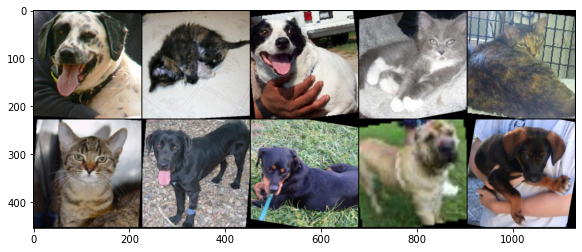

In [43]:
im = make_grid(images , nrow = 5)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im , (1,2,0)))

# 5. Defining Model Class

The Model will be as follows 
We are having 3 types of layers with following specifications
1. Conv2d Layer : <tt> kernel_size = 4 x4 </tt>  , <tt> stride = 2</tt> ,<tt> padding = 0</tt> ( the output and input channels are mentioned below)
2. MaxPool2d Layer :<tt> kernel_size = 2x2 </tt>  , <tt> stride = 2</tt>
3. Full Connected layers : ( the output and input mentioned are mentioned below)

The flow of Model will be:-

Input ( 3 x 224 x 224) ---> (Conv2d Layer , MaxPool2d Layer) ---> 4 x 55 x 55 ---> (Conv2d Layer , MaxPool2d Layer) ---> 8 X 13 X 13 --->  ( Conv2d layer) ---> 16 x 5 x 5 ---> 
400 x 1 ---> FC layer(in_features = 400 ,out_features = 120) ---> FC layer(in_features = 120 ,out_features = 84) ---> FC layer(in_features = 84 ,out_features = 2), softmax_layer ---> predictions


I have kept number of channels and parameters like kernel_size , padding etc. in the powers of 2 as these help to speed up things because of structure of computer memory
The paramaters for fully connected layers are kept to be 120,84 as many architectures like LeNet-5 have followed this pattern


In [60]:
class ModelNetwork(nn.Module):
    
    def __init__(self):
        
        super().__init__()
            
        self.conv_layers = nn.Sequential(
                
            nn.Conv2d(in_channels=3 ,out_channels=4 ,kernel_size=4 , stride = 2 ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2 , stride=2),
                
            nn.Conv2d(in_channels=4 , out_channels=8 , kernel_size=4 ,stride=2 ),
            nn.ReLU()
            nn.MaxPool2d(kernel_size=2 , stride=2),
            
            
            nn.Conv2d(in_channels=8 , out_channels=16 , kernel_size=4 ,stride=2 ),

               
        )
            
        self.lin_layers = nn.Sequential(
                
            nn.Linear(16*5*5 , 120),
            nn.BatchNorm1d(120),
            nn.Dropout( p = 0.6),
            
            nn.Linear(120 , 84),
            nn.Linear(84,2)
        )
            
    def forward(self , X):
        
        
        X = self.conv_layers(X.view(-1,3,224,224))
        X = X.view(-1 , 16*5*5)
        X = self.lin_layers(X)
        
        return X
    

SyntaxError: invalid syntax (<ipython-input-60-ca49e48b4f2a>, line 15)

# 6. Model Instantiation and defining loss criteria and optimizer

In [62]:
torch.manual_seed(101)
model = ModelNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model

ModelNetwork(
  (conv_layers): Sequential(
    (0): Conv2d(3, 4, kernel_size=(4, 4), stride=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(4, 8, kernel_size=(4, 4), stride=(2, 2))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2))
  )
  (lin_layers): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): Linear(in_features=120, out_features=84, bias=True)
    (2): Linear(in_features=84, out_features=2, bias=True)
  )
)

# 7. Performing Forward Propagation

While performing the forward propagation ,I will be performing 5 epochs and storing values of train_loss, test_loss, train_accuracy ,test_accuracy for every epoch for plotting graphs later on

In [68]:



epochs = 5
train_losses = []
test_losses = []

train_accuracy = []
test_accuracy = []


for i in range(epochs):
    
    
    
    for b,(X_train,y_train) in enumerate(train_loader):
        
        b+=1
        y_pred = model.forward(X_train)
        loss = criterion(y_pred , y_train)
        
        predicted = torch.max(y_pred ,1)[1]
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%1000==0:
            accuracy = accuracy_score(y_train , predicted)
            print(f'Epoch {i}  Batch: {b}  loss:{loss}' )
            
    train_losses.append(loss)
    train_accuracy.append(accuracy_score(y_train,predicted))
    
    
    with torch.no_grad():
        
        for b,(X_test,y_test) in enumerate(test_loader):
            
            y_val = model.forward(X_test)
            loss = criterion(y_val , y_test)
            
            predicted = torch.max(y_val ,1)[1]
            
            
    test_losses.append(loss)
    test_accuracy.append(accuracy_score(y_test , predicted))
            
    


Epoch 0  Batch: 1000  loss:0.5472395420074463
Epoch 1  Batch: 1000  loss:0.25025731325149536
Epoch 2  Batch: 1000  loss:0.6646653413772583
Epoch 3  Batch: 1000  loss:0.3680282235145569
Epoch 4  Batch: 1000  loss:0.5018671154975891


# 8. Plotting graphs of different parameters

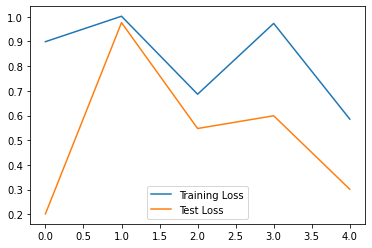

In [69]:
plt.plot(train_losses , label = 'Training Loss')
plt.plot(test_losses , label = 'Test Loss')

plt.legend()

# 9. Conclusion

Both the train and test losses are decreasing with epochs. 

In [76]:
train_losses

[tensor(0.8991, grad_fn=<NllLossBackward>),
 tensor(1.0022, grad_fn=<NllLossBackward>),
 tensor(0.6863, grad_fn=<NllLossBackward>),
 tensor(0.9731, grad_fn=<NllLossBackward>),
 tensor(0.5855, grad_fn=<NllLossBackward>)]

In [77]:
test_losses

[tensor(0.2014),
 tensor(0.9763),
 tensor(0.5475),
 tensor(0.5990),
 tensor(0.3014)]